In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import time

In [59]:
# GPU desteği var mı kontrol et
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Metal GPU backend
    print("MPS (GPU) kullanılacak.")
else:
    device = torch.device("cpu")
    print("GPU desteklenmiyor, CPU kullanılacak.")

MPS (GPU) kullanılacak.


In [60]:
def read_images(path, num_img):
    array = np.zeros((num_img, 64*32))
    i = 0
    for img in os.listdir(path):
        img_path = path + '/' + img
        img = Image.open(img_path, mode= 'r')
        data = np.asanyarray(img, dtype= 'uint8')
        data = data.flatten()
        array[i,:] = data
        i += 1
    return array

<h3>Negatives

In [61]:
train_negative_path = r'Data/LSIFIR/Classification/Train/neg'
num_train_negative_img = 43390

In [62]:
train_negative_array = read_images(train_negative_path, num_train_negative_img)

KeyboardInterrupt: 

In [ ]:
x_train_negative_tensor = torch.from_numpy(train_negative_array)

In [ ]:
y_train_negative_tensor = torch.zeros(num_train_negative_img, dtype= torch.long)

<h3>Positives

In [ ]:
train_positive_path = r'Data/LSIFIR/Classification/Train/pos'
num_train_positive_img = 10208

In [ ]:
train_positive_array = read_images(train_positive_path, num_train_positive_img)

In [ ]:
x_train_positive_tensor = torch.from_numpy(train_positive_array)

In [ ]:
y_train_positive_tensor = torch.ones(num_train_positive_img, dtype= torch.long)

<h3>Concat Train

In [ ]:
x_train = torch.cat((x_train_negative_tensor,x_train_positive_tensor),0)
y_train = torch.cat((y_train_negative_tensor,y_train_positive_tensor),0)

In [ ]:
print("x_train: ",x_train.size())
print("y_train: ",y_train.size())

x_train:  torch.Size([53598, 2048])
y_train:  torch.Size([53598])


<h3>Test Negative

In [ ]:
test_negative_path = r'Data/LSIFIR/Classification/Test/neg'
num_test_negative_img = 22050

In [ ]:
test_negative_array = read_images(test_negative_path,num_test_negative_img)

In [ ]:
x_test_negative_tensor = torch.tensor(test_negative_array[:20855,:])
y_test_negative_tensor = torch.zeros(20855, dtype= torch.long)

<h3>Test Positive

In [ ]:
test_positive_path = r'Data/LSIFIR/Classification/Test/pos'
num_test_positive_img = 5944

In [ ]:
test_positive_array = read_images(test_positive_path,num_test_positive_img)

In [ ]:
x_test_positive_tensor = torch.tensor(test_positive_array)
y_test_positive_tensor = torch.ones(num_test_positive_img, dtype=torch.long)

<h3>Concat Test

In [ ]:
x_test = torch.cat((x_test_negative_tensor, x_test_positive_tensor), 0)
y_test = torch.cat((y_test_negative_tensor, y_test_positive_tensor), 0)

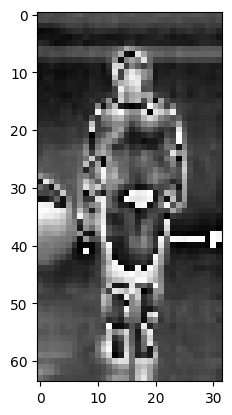

In [ ]:
plt.imshow(x_train[49001,:].reshape(64,32,), cmap='gray')

<h1>CNN

In [ ]:
#Hyperparameter
num_epochs = 5000
num_classes = 2
batch_size = 8933
learning_rate = 0.00001

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()

        self.conv1 = nn.Conv2d(1,10,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(10,16,5)

        self.fc1 = nn.Linear(16*13*5,520)
        self.fc2 = nn.Linear(520,130)
        self.fc3 = nn.Linear(130,num_classes)

    def forward(self,x):  # x inputumuz

        x = self.pool(F.relu(self.conv1(x))) #conv katmanından sonra RELU, sonrada Pooling yaptık
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1,16*13*5)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))  
        
        return x

In [ ]:
train = torch.utils.data.TensorDataset(x_train, y_train) # Train verilerimizi Troch için uygun formata getirme
trainloader = torch.utils.data.DataLoader(train,batch_size= batch_size, shuffle=True ) # Uygun formata getirilmiş train setimizi hyperparametreler ile initialize etme

test = torch.utils.data.TensorDataset(x_train, y_train) # Train verilerimizi Troch için uygun formata getirme
testloader = torch.utils.data.DataLoader(test,batch_size= batch_size, shuffle=False ) # Uygun formata getirilmiş train setimizi hyperparametreler ile initialize etme

In [ ]:
net = Net().to(device=device)  # to fonksiyonu modeli GPUda çalıştırmak için

In [ ]:
# Loss and Optimizer

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr= learning_rate, momentum= 0.8)

<h1 style="color:red;"> Train Section

In [64]:
start = time.time()

train_acc = []
test_acc = []
loss_list = []

use_gpu = True
step_counter=0
for epoch in range(num_epochs):
    step_counter += 1
    print("epoch: {}/{}".format(step_counter,num_epochs))
    for i, data in enumerate(trainloader,0):
        inputs, labels = data # Buradaki inputun size'ı şu şekilde = [batch_size, 64*32] (bunu istemiyoruz)
        inputs = inputs.view(batch_size, 1 , 64, 32) # reshape
        inputs = inputs.float() 

        if use_gpu:
            if torch.backends.mps.is_available():
                inputs, labels = inputs.to(device), labels.to(device)
            
        # zero gradient (Başlangıçta türevler otomatik olarak sıfırlanmadığı için elle sıfırlıyoruz)
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)

        # loss
        loss = criterion(outputs, labels)
        
        # backpropogation
        loss.backward()

        # update weights
        optimizer.step()
    
    # test
    correct = 0
    total = 0
    with torch.no_grad(): # backpropogation işlemini durdurmak için (train bitti test zamanı) ( ÖNEMLİ !!! )
        for data in testloader:
            images, labels = data

            images = images.view(batch_size, 1, 64, 32)
            images = images.float()

            if use_gpu:
                if torch.backends.mps.is_available():
                    images, labels = images.to(device), labels.to(device)

            output = net(images)

            _ , predicted = torch.max(outputs.data,1)  # Biz sadece ikinci değeri (indeksleri) kullanmak istiyoruz. İlk dönen değeri kullanmayacağımız için Python'da geleneksel olarak "_" değişkeni ile tutuyoruz.
            total += labels.size(0) # sıfırıncı index
            correct += (predicted == labels).sum().item() # item fonksiyonu çıkan sonucu gerçek intager sayıya çevirmek için

    acc1 = 100*correct/total
    print("Test accuracy: ", acc1)
    test_acc.append(acc1)

    # train
    correct = 0
    total = 0
    with torch.no_grad(): # backpropogation işlemini durdurmak için (train bitti test zamanı)
        for data in trainloader:
            images, labels = data

            images = images.view(batch_size, 1, 64, 32)
            images = images.float()

            if use_gpu:
                if torch.backends.mps.is_available():
                    images, labels = images.to(device), labels.to(device)

            output = net(images)

            _ , predicted = torch.max(outputs.data,1)  # Biz sadece ikinci değeri (indeksleri) kullanmak istiyoruz. İlk dönen değeri kullanmayacağımız için Python'da geleneksel olarak "_" değişkeni ile tutuyoruz.
            total += labels.size(0) # sıfırıncı index
            correct += (predicted == labels).sum().item() # item fonksiyonu çıkan sonucu gerçek intager sayıya çevirmek için

    acc2 = 100*correct/total
    print("Train accuracy: ", acc2)
    train_acc.append(acc2)

print("Training Done!")

end = time.time()
process_time = (end-start)/60
print("process time: ",process_time)

epoch: 1/5000
Test accuracy:  80.94705026306951
Train accuracy:  80.94331878055151
epoch: 2/5000
Test accuracy:  80.95451322810553
Train accuracy:  80.95451322810553
epoch: 3/5000
Test accuracy:  80.94705026306951
Train accuracy:  80.94331878055151
epoch: 4/5000
Test accuracy:  80.95451322810553
Train accuracy:  80.95451322810553
epoch: 5/5000
Test accuracy:  80.95451322810553
Train accuracy:  80.95451322810553
epoch: 6/5000
Test accuracy:  80.94705026306951
Train accuracy:  80.95078174558752
epoch: 7/5000
Test accuracy:  80.95451322810553
Train accuracy:  80.95451322810553
epoch: 8/5000
Test accuracy:  80.95451322810553
Train accuracy:  80.95451322810553
epoch: 9/5000
Test accuracy:  80.95451322810553
Train accuracy:  80.95451322810553
epoch: 10/5000
Test accuracy:  80.95451322810553
Train accuracy:  80.95451322810553
epoch: 11/5000
Test accuracy:  80.95451322810553
Train accuracy:  80.95451322810553
epoch: 12/5000
Test accuracy:  80.95451322810553
Train accuracy:  80.95451322810553
e

KeyboardInterrupt: 